# Курсовая работа

---
## по теме: "Построение рекомендательной системы в области закупок с помощью графовых нейронных сетей"

Выполнила: студентка учебной группы\
ПМ21-1\
Стаханова Анастасия Андреевна


# 1. Импорт библиотек

In [ ]:
!pip install pymorphy2
#!pip install torch==2.1.2
#!pip install DGL==2.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 53.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=073a8de858152121c2be182d4ccdf96936bf92b6835992e5215a400831e3c83e
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
!pip install DGL==2.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 59.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux20

In [ ]:
!pip install torch==2.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 7.4 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.20.5
    Uninstalling nvidia-nccl-cu12-2.20.5:
      Successfully uninstalled nvidia-nccl-cu12-2.20.5
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 2.1

In [246]:
import pandas as pd
import numpy as np
import random
import re
import string
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from numba import jit
import time

import pymorphy2
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import scipy.sparse as sp
import itertools

import dgl
import dgl.function as fn
from dgl.nn import SAGEConv, GraphConv, GATConv

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, classification_report

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Загрузка датасета

In [ ]:
df = pd.read_excel('/content/ContractSearch(1-5000)_06.05.2024 (4).xlsx')
df.head()

,Номер реестровой записи контракта,Заказчик: наименование,Заказчик: ИНН,Предмет контракта,"Объект закупки: наименование товаров, работ, услуг",Цена контракта,Объект закупки: код позиции,"Объект закупки: сумма, рублей","Информация о поставщиках (исполнителях, подрядчиках) по контракту: наименование юридического лица (ф.и.о. физического лица)","Информация о поставщиках (исполнителях, подрядчиках) по контракту: ИНН"
0,'3183504891023000030',МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,'1835048910','№ 32787 Хлебобулочные изделия для нужд учрежд...,Хлеб недлительного хранения,"'252 032,14'",10.71.11.110-00000004,84010.01,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",'5920034144'
1,'3183504891023000030',МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,'1835048910','№ 32787 Хлебобулочные изделия для нужд учрежд...,Хлеб недлительного хранения,"'252 032,14'",10.71.11.110-00000002,84010.02,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",'5920034144'
2,'3183504891023000030',МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,'1835048910','№ 32787 Хлебобулочные изделия для нужд учрежд...,Булочные изделия,"'252 032,14'",10.71.11.120-00000004,84010.03,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",'5920034144'
3,'2781020117024000019',САНКТ-ПЕТЕРБУРГСКОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ...,'7810201170',"'Оказание услуг на отпуск питьевой воды, прием...",Вода питьевая,"'100 740,00'",36.00.11.000,'100740.00',"ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ ""ВОДОКАН...",'7830000426'
4,'2502700146623000079',ГОСУДАРСТВЕННОЕ КАЗЁННОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРА...,'5027001466','Поставка продуктов питания : Поставка хлеба д...,Хлеб ржаной,"'179 550,00'",10.86.10.700,'45600.00',"АКЦИОНЕРНОЕ ОБЩЕСТВО ""ЕГОРЬЕВСКИЙ ХЛЕБОКОМБИНАТ""",'5011017573'


В данном датасете имеются:\
1) Номер контракта (ID) - contract_number\
2) Наименование заказчика - customer_name\
3) ИНН заказчика (который мы будем использовать в качестве ID) - customer_INN\
4) Предмет конракта - contract_predmet\
5) Объекты закупки - contract_elems\
6) Сумма всего контракта (в один конракт могут входить несколько позиций или же несколько закупок) - contract_price\
7) Специальный код закупки - order_code\
8) Сумма закупки - order_price\
9) Наименование поставщика - provider_name\
10) ИНН поставщика (который мы будем использовать в качестве ID) - provider_INN

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29832 entries, 0 to 29831
Data columns (total 10 columns):
 #   Column                                                                                                                       Non-Null Count  Dtype 
---  ------                                                                                                                       --------------  ----- 
 0   Номер реестровой записи контракта                                                                                            29832 non-null  object
 1   Заказчик: наименование                                                                                                       29832 non-null  object
 2   Заказчик: ИНН                                                                                                                29832 non-null  object
 3   Предмет контракта                                                                                                        

In [ ]:
print('Длина датасета = ', len(df))
print('Количество столбцов = ', len(df.columns))

Длина датасета =  29832
Количество столбцов =  10


Изменение наименований столбцов для удобства

In [ ]:
new_names = ['contract_number','customer_name','customer_INN',
             'contract_predmet','contract_elems','contract_price',
             'order_code','order_price','provider_name','provider_INN']
df.columns = new_names

In [ ]:
print('Количество пропущенных значений:')
df.isnull().sum()

Количество пропущенных значений:


contract_number      0
customer_name        0
customer_INN         0
contract_predmet    18
contract_elems       0
contract_price       0
order_code           0
order_price          3
provider_name        0
provider_INN         0
dtype: int64

# 3. Преобразования датасета

## 3.1 Работа с типами данных

Функция для преобразования ИНН в число

In [ ]:
def work_with_INN(df, column_name):
    df[column_name] = df[column_name].astype(str).str.replace("'", '').apply(lambda x: int(x))
work_with_INN(df, 'customer_INN')
work_with_INN(df, 'provider_INN')

Функция для корректного отображения цены контракта

In [ ]:
def convert_price(df, column_name):
    df[column_name] = df[column_name].astype(str).str.replace("'", '').str.replace(",", ".").str.replace(" ", "").apply(lambda x: float(x))
convert_price(df, 'contract_price')

Функция для корректного отображения цены закупки. Также если значение order_price пустое, а contract_price содержит в себе какую-то цену, то функция добавляет информацию о ней в пустующую ячейку в солбец order_price

In [ ]:
def process_column(df, column_name, default_column_name):
    for index, value in df[column_name].items():
        if isinstance(value, str):
            value = value.replace("'", "").replace(" ", "").replace(",", ".")
            value = float(value)
            if value == '':
                df.loc[index, column_name] = float(df.loc[index, default_column_name])
            else:
                df.loc[index, column_name] = float(value)
    df[column_name] = df[column_name].apply(lambda x: float(x))
process_column(df, 'order_price', 'contract_price')

## 3.2 Изменение содержания данных

Создание нового столбца 'product', в который войдут contract_elems и contract_predmet

In [ ]:
df['product'] = df['contract_elems'] + ' ' + df['contract_predmet']
df = df.drop(['contract_elems', 'contract_predmet'], axis =1)

Убираем колонку 'contract_price', так как она содержит в себе информацию о цене всего контракта, а не конкретно одной закупки

In [ ]:
df = df.drop(['contract_price'], axis = 1)

## 3.3 Удаление пропусков и дубликатов

In [ ]:
df = df.dropna()
df = df.drop_duplicates()
len(df)

28471

Теперь нам не понадбится колонка 'order_code', так как именно она помогла отследить и удалить дубликаты (ИНН и order_code давали уникальное значение для каждого контракта)

In [ ]:
df = df.drop(['order_code'], axis = 1)

## 3.4 Создание уникального кода закупки

Удаленный 'order_code' - это уникальный номер всего контракта, поэтому в некоторых строках он одинаковый, так как в контракте могут быть несколько объектов (закупок). Но нам нужно добиться уникального номера именно для каждой закупки. Поэтому создадим новую колонку с уникальным кодом (ID) для удобства дальнейшей работы.

In [ ]:
def add_ID(df):
    random_values = [''.join(random.choices(string.digits, k=15)) for _ in range(len(df))]
    new_column_name = 'ID'
    df[new_column_name] = random_values
    return df

df = add_ID(df)
df = df[['ID'] + [x for x in df.columns if x != 'ID']]
df = df.drop(['contract_number'], axis = 1)
df.head(3)

,ID,customer_name,customer_INN,order_price,provider_name,provider_INN,product
0,747261344941507,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.01,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...
1,612772825091119,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.02,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...
2,289915043749578,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.03,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Булочные изделия '№ 32787 Хлебобулочные издели...


In [ ]:
df['ID'] = df['ID'].apply(lambda x: int(x))

## 3.5 Итоги обработки

In [ ]:
df.head(3)

,ID,customer_name,customer_INN,order_price,provider_name,provider_INN,product
0,747261344941507,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.01,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...
1,612772825091119,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.02,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...
2,289915043749578,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.03,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Булочные изделия '№ 32787 Хлебобулочные издели...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28471 entries, 0 to 29831
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             28471 non-null  int64  
 1   customer_name  28471 non-null  object 
 2   customer_INN   28471 non-null  int64  
 3   order_price    28471 non-null  float64
 4   provider_name  28471 non-null  object 
 5   provider_INN   28471 non-null  int64  
 6   product        28471 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 1.7+ MB


В итоговом датасете имеются:\
1) Номер закупки - ID\
2) Наименование заказчика - customer_name\
3) ИНН заказчика - customer_INN\
4) Сумма закупки - order_price\
5) Наименование поставщика - provider_name\
6) ИНН поставщика - provider_INN\
7) Содержание закупки (товар/услуга) - product

In [ ]:
df.to_csv('all_data.csv', index = False)

# 4. Разделение датасета

## 4.1 Ребра графа (edges)

In [ ]:
df = pd.read_csv('/content/all_data.csv')

In [ ]:
edges = df[['ID', 'customer_INN', 'provider_INN', 'order_price']]
edges.head(5)

,ID,customer_INN,provider_INN,order_price
0,747261344941507,1835048910,5920034144,84010.01
1,612772825091119,1835048910,5920034144,84010.02
2,289915043749578,1835048910,5920034144,84010.03
3,149002412155659,7810201170,7830000426,100740.00
4,903155564175008,5027001466,5011017573,45600.00


In [ ]:
print('Длина датасета = ', len(edges))
print('Количество колонок = ', len(edges.columns))

Длина датасета =  28471
Количество колонок =  4


## 4.2 Вершины графа (nodes)

In [ ]:
nod = pd.concat([df['customer_INN'], df['provider_INN']]).unique()
len(nod)

3888

In [ ]:
print('Кол-во уникальных ИНН поставщиков -', len(df['provider_INN'].unique()))

Кол-во уникальных ИНН поставщиков - 2026


In [ ]:
print('Кол-во уникальных ИНН заказщиков -', len(df['customer_INN'].unique()))

Кол-во уникальных ИНН заказщиков - 1862


Функция, которая выписывает все уникальные ИНН как заказчиков, так и поставщиков и ищет для них всю информацию о продуктах, с которыми они встречались

In [ ]:
def extract_product_info(df, nodes):
    unique_prov = list(df['provider_INN'].unique())
    products_info = []
    for node in nodes:
      if node in unique_prov:
        supplier_data = df[df['provider_INN'] == node]

        product_info_list = list(supplier_data['product'].astype(str).unique())
        product_info = ', '.join(product_info_list)

        products_info.append({'INN': node, 'product': product_info})
      else:
        supplier_data = df[df['customer_INN'] == node]

        product_info_list = list(supplier_data['product'].astype(str).unique())
        product_info = ', '.join(product_info_list)
        products_info.append({'INN': node, 'product': product_info})

    new_dataset = pd.DataFrame(products_info)
    new_dataset = new_dataset.sort_values(by='INN').reset_index(drop=True)

    return new_dataset
nodes = extract_product_info(df, nod)
nodes

,INN,product
0,104008357,Филе тресковых рыб мороженое (Филе минтая) 'П...
1,104008396,"Молоко, 2,5%, 1 л 'Поставка продуктов питания..."
2,105003182,"Молоко, 2,5%, 1 л 'Поставка продуктов питания..."
3,105013462,Смесь сушеных фруктов (сухой компот) 'Сухофрук...
4,105019055,Молоко питьевое 'продукты питания (молоко пить...
...,...,...
3883,862199205474,Выполнение работ по текущему ремонту 5-ой груп...
3884,910209932045,Говядина замороженная для детского питания. От...
3885,920100129510,Мясо сельскохозяйственной птицы охлажденное дл...
3886,920355485507,Филе лососевых рыб мороженое. отсутствует 'на ...


In [ ]:
print('Длина датасета = ', len(nodes))
print('Количество колонок = ', len(nodes.columns))

Длина датасета =  3888
Количество колонок =  2


## 5. Лемматизация информации и продуктах

In [ ]:
morph = pymorphy2.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

In [ ]:
@jit
def preprocess_text_numba(text):
    # Удаление всех символов, кроме букв
  text = re.sub(r'[^А-Яа-я]', ' ', text)
  words = text.lower().split()
    # Удаление стоп-слов
  filtered_words = [w for w in words if w not in stop_words]
    # Лемматизация
  lemmatized_words = [morph.parse(word)[0].normal_form for word in filtered_words]

  return ' '.join(lemmatized_words)

def preprocess_column_numba(df, column_name):
    tqdm.pandas()

    def preprocess_row(row):
        row[column_name] = preprocess_text_numba(row[column_name])
        return row

    updated_df = df.progress_apply(preprocess_row, axis=1)

    return updated_df

dff = preprocess_column_numba(nodes, 'product')
dff.head(3)

100%|██████████| 3888/3888 [02:28<00:00, 26.20it/s]


,INN,product
0,104008357,филе тресковый рыба мороженое филе минтай пост...
1,104008396,молоко л поставка продукт питание молочный про...
2,105003182,молоко л поставка продукт питание молочный про...


Эта функция обрабатывает строки в столбце следующим образом: если в строке менее 6 слов, то добавляются самые часто встречающиеся слова, чтобы длина строки стала равной 6; если слов больше или равно 6, то выбирается топ 6 самых встречающихся. В результате, в каждой строке будет содержаться 6 слов в виде строки.

In [ ]:
def process_words_in_column(df, column_name):
    def fill_missing_words(words):
        count = Counter(words)
        while len(words) != 6:
            most_common_word = count.most_common(1)[0][0]
            words.append(most_common_word)
        return ' '.join(words)

    def get_top_words(words):
        count = Counter(words)
        top_words = [word for word, _ in count.most_common(6)]
        return ' '.join(top_words)

    def process_row(row):
        if isinstance(row[column_name], str):
            words = row[column_name].split()
        elif isinstance(row[column_name], list):
            words = row[column_name]
        else:
            words = []

        if len(words) == 0:
          return ''
        elif len(words) > 6:
            return get_top_words(words)
        else:
            return fill_missing_words(words)

    df[column_name] = df.apply(process_row, axis=1)

    return df

In [ ]:
processed_df = process_words_in_column(dff, 'product')
processed_df

,INN,product
0,104008357,поставка продукт питание молочный продукция рыба
1,104008396,поставка продукт питание молочный продукция гр
2,105003182,продукт питание поставка молочный продукция мо...
3,105013462,крупа изделие рис горох фасоль печение
4,105019055,молоко питьевой продукт питание молоко питьевой
...,...,...
3883,862199205474,сиверский выполнение работа текущий ремонт ой
3884,910209932045,говядина питание субпродукт заморозить отсутст...
3885,920100129510,куриный питание мясо сельскохозяйственный птиц...
3886,920355485507,рыба филе мороженое отсутствовать поставка про...


In [ ]:
for i in processed_df['product']:
  if len(i.split()) < 6 and len(i.split())!=0:
    print(i)
    print('Где-то есть строка не той длины')

In [ ]:
nodes_pro = processed_df
nodes_pro = nodes_pro.fillna('')

In [ ]:
edges.to_csv('d_edges.csv', index = False)
nodes_pro.to_csv('d_nodes.csv', index = False)

# 6. Векторизация

Свойства графа не могут содержать данные в виде строкового формата, поэтому столбец 'product' должен быть векторизирован.
Для этого использован  TF-IDF

In [ ]:
nodes = pd.read_csv('/content/d_nodes.csv')
nodes.head(1)

,INN,product
0,104008357,поставка продукт питание молочный продукция рыба


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(nodes['product'].values.astype('U').tolist())
nodes_info = torch.tensor(X.toarray())
nodes_info

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [ ]:
nodes_info.shape

torch.Size([3888, 2286])

# 5. Создание графа

## 5.1 Подготовка вершин

In [ ]:
edges = pd.read_csv('/content/d_edges.csv')
edges.head(1)

,ID,customer_INN,provider_INN,order_price
0,747261344941507,1835048910,5920034144,84010.01


In [ ]:
all_inn = sorted(pd.concat([edges['customer_INN'], edges['provider_INN']]).unique().tolist())
counter = {val: i for i, val in enumerate(all_inn)}

In [ ]:
customer_inn = [counter[i] for i in edges['customer_INN']]
provider_inn = [counter[i] for i in edges['provider_INN']]
nodes_dict = {'customer_INN':customer_inn,
              'provider_INN': provider_inn}

In [ ]:
nodes = pd.DataFrame(nodes_dict)
nodes

,customer_INN,provider_INN
0,420,2024
1,420,2024
2,420,2024
3,3199,3347
4,1831,1819
...,...,...
28466,469,494
28467,563,557
28468,493,581
28469,593,528


In [ ]:
nodes.to_csv('Ноды.csv')

## 5.2 Граф

In [ ]:
g = dgl.graph((nodes['customer_INN'], nodes['provider_INN']))
g.ndata['products'] = nodes_info
g.edata['order_price'] = torch.tensor(edges['order_price'])

In [ ]:
print('Узлы: ', g.nodes())
print('Ребра:', g.edges())
print('Кол-во вершин = ', g.num_nodes())
print('Кол-во рёбер = ', g.num_edges())
print(' ')
print('Ребра (вместе с ID):', g.edges(form='all'))
print('Фичи узлов: ', g.ndata)
print(' ')
print('Входящие степени узлов в графе:', g.in_degrees())
print('Исходящие степени узлов в графе:', g.out_degrees())

Узлы:  tensor([   0,    1,    2,  ..., 3885, 3886, 3887])
Ребра: (tensor([420, 420, 420,  ..., 493, 593, 470]), tensor([2024, 2024, 2024,  ...,  581,  528,  494]))
Кол-во вершин =  3888
Кол-во рёбер =  28471
 
Ребра (вместе с ID): (tensor([420, 420, 420,  ..., 493, 593, 470]), tensor([2024, 2024, 2024,  ...,  581,  528,  494]), tensor([    0,     1,     2,  ..., 28468, 28469, 28470]))
Фичи узлов:  {'products': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)}
 
Входящие степени узлов в графе: tensor([ 0,  0, 13,  ...,  3,  3,  1])
Исходящие степени узлов в графе: tensor([8, 5, 0,  ..., 0, 0, 0])


## 5.3 Визуализация графа

In [ ]:
G = dgl.to_networkx(g)

In [ ]:
colors_dict = {}
for i in G.nodes():
  if i in nodes['customer_INN'].tolist():
    colors_dict[i] = '#B0C4DE'
  else:
    colors_dict[i] = '#8b41c4'

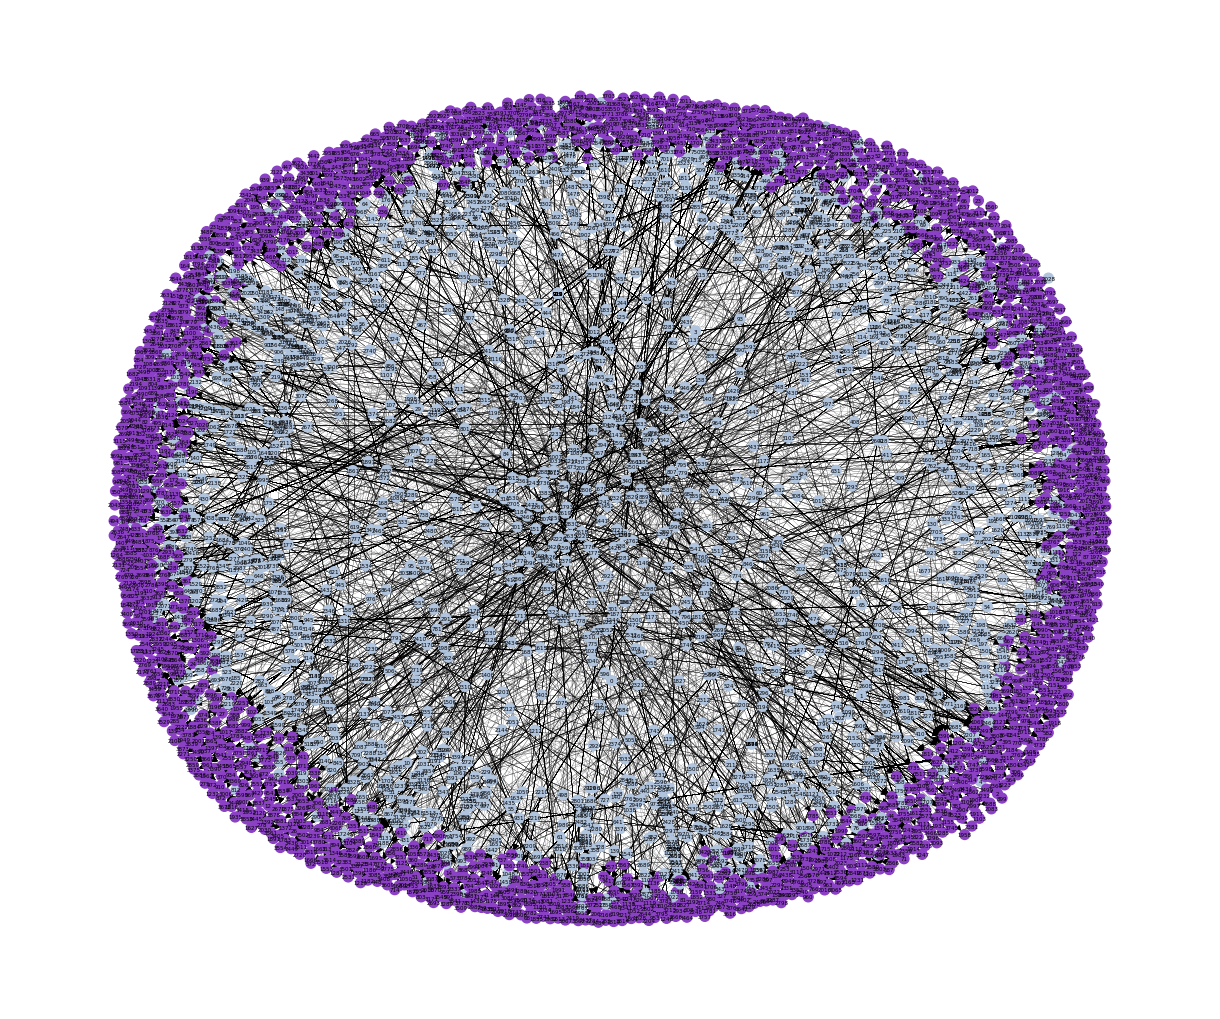

In [ ]:
plt.figure(figsize=(12, 10))
nx.draw(G,
        with_labels=True,
        font_size=4,
        node_size=50,
        width=0.1,
        node_color = [colors_dict[node] for node in G.nodes()])
plt.show()

customer_INN - голубой цвет\
provider_INN - фиолетовый цвет

# 6. Разделение на тренировочную и тестовую выборки

In [ ]:
def split_graph(g):
    cust, prov = g.edges()
    indices = np.arange(g.num_edges()) # Индексы вершин
    n_nod = g.num_nodes()
    random_indices = np.random.permutation(indices) #рандомный порядок вершин

    test_ratio = 0.1
    test_size = int(len(random_indices) * test_ratio)
    train_size = g.num_edges() - test_size
    print('test_size = ', test_size)
    print('train_size = ', train_size)

    test_pos_cust, test_pos_prov = cust[random_indices[:test_size]], prov[random_indices[:test_size]]
    train_pos_cust, train_pos_prov = cust[random_indices[test_size:]], prov[random_indices[test_size:]]

    # Разреженная матрица смежности (информация о позитивных ребрах)
    adj = sp.coo_matrix((np.ones(len(cust)), (cust.numpy(), prov.numpy())), shape=(n_nod, n_nod))
    # Информация об отсутствующих ребрах (негативных)
    adj_negative = 1 - adj.todense() - np.eye(n_nod)
    negative_cust, negative_prov = np.where(adj_negative != 0)

    negative_random_indices = np.random.choice(len(negative_cust), g.num_edges())
    test_negative_cust, test_negative_prov= negative_cust[negative_random_indices[:test_size]], negative_prov[negative_random_indices[:test_size]]
    train_negative_cust, train_negative_prov = negative_cust[negative_random_indices[test_size:]], negative_prov[negative_random_indices[test_size:]]

    train_g = dgl.remove_edges(g, random_indices[:test_size])
    test_g = dgl.remove_edges(g, random_indices[test_size:])
    train_pos_g = dgl.graph((train_pos_cust, train_pos_prov), num_nodes=n_nod)
    train_negative_g = dgl.graph((train_negative_cust, train_negative_prov), num_nodes=n_nod)
    test_pos_g = dgl.graph((test_pos_cust, test_pos_prov), num_nodes=n_nod)
    test_negative_g = dgl.graph((test_negative_cust, test_negative_prov), num_nodes=n_nod)

    return train_g, train_pos_g, train_negative_g, test_pos_g, test_negative_g, test_g

train_g, train_pos_g, train_negative_g, test_pos_g, test_negative_g, test_g = split_graph(g)

test_size =  2847
train_size =  25624


In [ ]:
print("Train Graph:", train_g)
print("Test Graph:", test_g)
print("Train Positive Edges:", train_pos_g.edges())
print("Train Negative Edges:", train_negative_g.edges())
print("Test Positive Edges:", test_pos_g.edges())
print("Test Negative Edges:", test_negative_g.edges())

Train Graph: Graph(num_nodes=3888, num_edges=25624,
      ndata_schemes={'products': Scheme(shape=(2286,), dtype=torch.float64)}
      edata_schemes={'order_price': Scheme(shape=(), dtype=torch.float64)})
Test Graph: Graph(num_nodes=3888, num_edges=2847,
      ndata_schemes={'products': Scheme(shape=(2286,), dtype=torch.float64)}
      edata_schemes={'order_price': Scheme(shape=(), dtype=torch.float64)})
Train Positive Edges: (tensor([ 718,  718,  718,  ...,  340,  646, 1157]), tensor([3560, 3560, 3560,  ...,  345,  658, 1356]))
Train Negative Edges: (tensor([ 599,  706, 2970,  ..., 1369,  142,  840]), tensor([3091, 2873,  528,  ..., 2319, 3823,  980]))
Test Positive Edges: (tensor([3029, 1614, 1731,  ...,  728, 1704, 1818]), tensor([3553, 3563, 3166,  ...,  734, 3654, 3678]))
Test Negative Edges: (tensor([  23, 2400, 2381,  ...,  626,  933,  916]), tensor([2323,  453,  389,  ..., 2216, 3845,  255]))


# 7. Используемые метрики

In [ ]:
def compute_loss(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score])
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])
    ])
    # Вычисляем бинарную перекрестную энтропию
    loss = F.binary_cross_entropy_with_logits(scores, labels)
    return loss

In [ ]:
def compute_accuracy(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score]).detach().numpy()
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])
    ]).detach().numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return accuracy_score(labels, pred_labels)

In [ ]:
def compute_f1(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score]).detach().numpy()
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])]
    ).detach().numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return f1_score(labels, pred_labels)

In [ ]:
def compute_auc(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score]).numpy()
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])
    ]).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
def compute_conf_matrix(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score]).detach().numpy()
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])
    ]).detach().numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return confusion_matrix(labels, pred_labels)

# 8. DotPredictor

Будем использовать следующий класс для предсказания наличия ребра между двумя узлами.
Этот класс принимает граф и признаки узлов, затем вычисляет скалярные произведения для пар узлов при помощи функции fn.u_dot_v('h', 'h', 'score'), сохраняет результат в атрибуте ребер score.

In [ ]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope(): # создает локальную копию данных узлов и ребер графа
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:,0]

# 9. Модели и обучение

## 9.1 GraphSAGE (из библиотеки)

In [91]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hid_feats):
        super(GraphSAGE, self).__init__()
        self.layer1 = SAGEConv(in_feats, hid_feats, 'mean')
        self.layer2 = SAGEConv(hid_feats, hid_feats, 'mean')

    def forward(self, g, features):
        h = self.layer1(g, features)
        h = F.relu(h)
        h = self.layer2(g,h)
        return h

In [97]:
model1 = GraphSAGE(train_g.ndata["products"].shape[1], 2)
model1 = model1.double()
predictor1 = DotPredictor()
optimizer = torch.optim.Adam(
    itertools.chain(model1.parameters(), predictor1.parameters()), lr=0.01
)

In [98]:
loss_values, f1_values = [], []
start_time = time.time()
for i in range(250):
    h1 = model1(train_g, train_g.ndata["products"])
    positive_score = predictor1(train_pos_g, h1)
    negative_score = predictor1(train_negative_g, h1)
    loss = compute_loss(positive_score, negative_score)
    accuracy = round(compute_accuracy(positive_score, negative_score), 5)
    f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())
    loss = round(loss.item(), 5)
    f1_values.append(f1_sc)

    if i % 10 == 0:
        print(f"In epoch {i}, Loss: {loss}, Accuracy: {accuracy}")
end_time = time.time()
elapsed_time = end_time - start_time


with torch.no_grad():
    positive_score_GD = predictor1(test_pos_g, h1)
    negative_score_GD = predictor1(test_negative_g, h1)
    positive_prob_GD = torch.sigmoid(positive_score_GD)
    negative_prob_GD = torch.sigmoid(negative_score_GD)

def metrics():
  accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
  f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
  auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)
  t = round(elapsed_time, 5)
  return accurary, f1, auc_, t

accurary1, f11, auc_1, t1 = metrics()
print ('Accuracy = :', accurary1)
print ('F1_score = :', f11)
print ('Auc = :', auc_1)
print('Time =', t1)

In epoch 0, Loss: 0.70633, Accuracy: 0.5
In epoch 10, Loss: 0.66755, Accuracy: 0.5
In epoch 20, Loss: 0.64102, Accuracy: 0.49994
In epoch 30, Loss: 0.61125, Accuracy: 0.52264
In epoch 40, Loss: 0.5797, Accuracy: 0.83759
In epoch 50, Loss: 0.54916, Accuracy: 0.83837
In epoch 60, Loss: 0.52137, Accuracy: 0.84062
In epoch 70, Loss: 0.4979, Accuracy: 0.84042
In epoch 80, Loss: 0.47967, Accuracy: 0.83986
In epoch 90, Loss: 0.46621, Accuracy: 0.84144
In epoch 100, Loss: 0.45634, Accuracy: 0.84593
In epoch 110, Loss: 0.44905, Accuracy: 0.84751
In epoch 120, Loss: 0.44338, Accuracy: 0.84897
In epoch 130, Loss: 0.43854, Accuracy: 0.85135
In epoch 140, Loss: 0.43428, Accuracy: 0.85408
In epoch 150, Loss: 0.43058, Accuracy: 0.85576
In epoch 160, Loss: 0.42727, Accuracy: 0.85836
In epoch 170, Loss: 0.42413, Accuracy: 0.86138
In epoch 180, Loss: 0.42109, Accuracy: 0.86296
In epoch 190, Loss: 0.41823, Accuracy: 0.86462
In epoch 200, Loss: 0.41564, Accuracy: 0.86513
In epoch 210, Loss: 0.41318, Accur

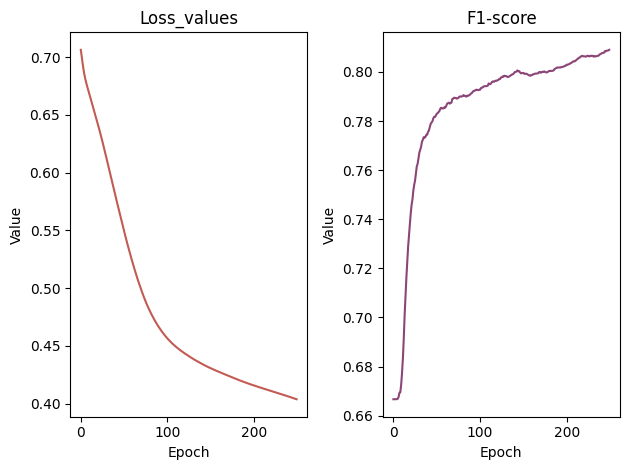

In [99]:
plt.subplot(1, 2, 1)
plt.plot(loss_values, color='#c25b53')
plt.title('Loss_values')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(f1_values, color='#8c4577')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

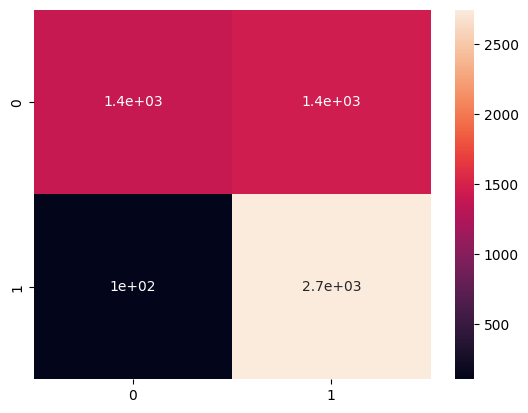

array([[1401, 1446],
       [ 104, 2743]])

In [100]:
matrix = compute_conf_matrix(positive_prob_GD, negative_prob_GD)
sns.heatmap(matrix, annot=True)
plt.show()
matrix

TP = 1401: истинно позитивных предсказаний.\
FP = 1446: ложно позитивных предсказаний.\
FN = 104: ложно негативных предсказаний.\
TN = 2743: истинно негативных предсказаний.

Высокое количество TN: Модель правильно классифицирует большинство отрицательных примеров \
Достаточно высокое TP и FP: Модель правильно классифицирует половну положительных примеров, при этом часто классифицирует негативные предсказания как позитивные\
Низкое FN: Модель редко ошибается, классифицируя отрицательные примеры, как положительные


In [130]:
TP1, FP1, FN1, TN1 = 1401, 1446, 104, 2743

### 9.1.1 Кросс-валидация

In [103]:
kf = KFold(n_splits=5)
loss_values, f1_values = [], []
accuracies, f1_scores, auc_scores = [], [], []
start_time = time.time()

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hid_feats):
        super(GraphSAGE, self).__init__()
        self.layer1 = SAGEConv(in_feats, hid_feats, 'mean')
        self.layer2 = SAGEConv(hid_feats, hid_feats, 'mean')

    def forward(self, g, features):
        h = self.layer1(g, features)
        h = F.relu(h)
        h = self.layer2(g,h)
        return h

for fold, (train_index, val_index) in enumerate(kf.split(train_g.ndata["products"])):
    print(f"Fold {fold+1}")

    # Создание тренировочных и валидационных наборов данных
    train_subset = train_index
    val_subset = val_index

    # Обучение модели
    model1 = GraphSAGE(train_g.ndata["products"].shape[1], 2).double()
    predictor1 = DotPredictor()
    optimizer = torch.optim.SGD(
        itertools.chain(model1.parameters(), predictor1.parameters()), lr=0.3
    )

    for i in range(200):
        model1.train()
        h1 = model1(train_g, train_g.ndata["products"])
        positive_score = predictor1(train_pos_g, h1)
        negative_score = predictor1(train_negative_g, h1)
        loss = compute_loss(positive_score, negative_score)
        accuracy = round(compute_accuracy(positive_score, negative_score), 5)
        f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"In epoch {i}, Loss: {round(loss.item(), 5)}, Accuracy: {accuracy}")

    model1.eval()
    with torch.no_grad():
        h1 = model1(train_g, train_g.ndata["products"])
        positive_score_GD = predictor1(test_pos_g, h1)
        negative_score_GD = predictor1(test_negative_g, h1)
        positive_prob_GD = torch.sigmoid(positive_score_GD)
        negative_prob_GD = torch.sigmoid(negative_score_GD)

        accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
        f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
        auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)

        accuracies.append(accurary)
        f1_scores.append(f1)
        auc_scores.append(auc_)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.5f}")
print(f"Average F1_score: {sum(f1_scores) / len(f1_scores):.5f}")
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.5f}")
print(f"Elapsed Time: {elapsed_time:.5f}")

Fold 1
In epoch 0, Loss: 0.69624, Accuracy: 0.5
In epoch 10, Loss: 0.69323, Accuracy: 0.5
In epoch 20, Loss: 0.68792, Accuracy: 0.5
In epoch 30, Loss: 0.67254, Accuracy: 0.60506
In epoch 40, Loss: 0.64856, Accuracy: 0.61154
In epoch 50, Loss: 0.63008, Accuracy: 0.63249
In epoch 60, Loss: 0.61866, Accuracy: 0.64215
In epoch 70, Loss: 0.61088, Accuracy: 0.64683
In epoch 80, Loss: 0.60485, Accuracy: 0.65993
In epoch 90, Loss: 0.59976, Accuracy: 0.66088
In epoch 100, Loss: 0.59524, Accuracy: 0.66305
In epoch 110, Loss: 0.59107, Accuracy: 0.66465
In epoch 120, Loss: 0.58711, Accuracy: 0.66734
In epoch 130, Loss: 0.58321, Accuracy: 0.66711
In epoch 140, Loss: 0.57926, Accuracy: 0.66912
In epoch 150, Loss: 0.57514, Accuracy: 0.66877
In epoch 160, Loss: 0.5708, Accuracy: 0.68518
In epoch 170, Loss: 0.56627, Accuracy: 0.68672
In epoch 180, Loss: 0.56169, Accuracy: 0.69433
In epoch 190, Loss: 0.55722, Accuracy: 0.69464
Fold 2
In epoch 0, Loss: 0.69268, Accuracy: 0.5
In epoch 10, Loss: 0.68413, A

Средняя точность = 0.71900 указывает на то, что в среднем модель правильно классифицировала около 72% примеров на всех фолдах. То есть, примерно 3 из 4 примеров были правильно классифицированы.

Среднее значение F1-меры =  0.74145 показывает среднюю гармоническую среднюю точность и полноту модели на всех фолдах. Это значение указывает на сбалансированность модели между точностью и полнотой.

Среднее значение AUC = 0.82577 представляет собой среднюю площадь под кривой ROC (Receiver Operating Characteristic) для всех фолдов. Это показывает, насколько хорошо модель разделяет классы. В данном случае модель это делает достаточно хорошо

In [131]:
Average_Accuracy1 = 0.71900
Average_F1_score1 = 0.74145
Average_AUC1 = 0.82577
Elapsed_Time1 = 138.20209

In [132]:
torch.save(model1.state_dict(), 'model1.pth')
torch.save(predictor1.state_dict(), 'predictor1.pth')

## 9.2 GraphConv_x2 (два слоя)

In [110]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, dropout = 0.5):
        super(GCN, self).__init__()
        self.layer1 = GraphConv(in_feats, hid_feats, allow_zero_in_degree=True)
        self.layer2 = GraphConv(hid_feats, out_feats, allow_zero_in_degree=True)
        self.batch_norm = nn.BatchNorm1d(hid_feats)
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, features):
        h = self.layer1(g, features)
        h = F.leaky_relu(h)
        h = self.batch_norm(h)
        h = self.dropout(h)
        h = self.layer2(g, h)
        return h

In [111]:
model2 = GCN(train_g.ndata["products"].shape[1], 128, 2)
model2 = model2.double()
predictor1 = DotPredictor()
optimizer = torch.optim.SGD(
    itertools.chain(model2.parameters(), predictor1.parameters()), lr=0.1
)

loss_values, f1_values = [], []
start_time = time.time()
for i in range(150):
    h1 = model2(train_g, train_g.ndata["products"])
    positive_score = predictor1(train_pos_g, h1)
    negative_score = predictor1(train_negative_g, h1)
    loss = compute_loss(positive_score, negative_score)
    accuracy = round(compute_accuracy(positive_score, negative_score), 5)
    f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())
    loss = round(loss.item(), 5)
    f1_values.append(f1_sc)

    if i % 10 == 0:
        print(f"In epoch {i}, Loss: {loss}, Accuracy: {accuracy}")
end_time = time.time()
elapsed_time = end_time - start_time


with torch.no_grad():
    positive_score_GD = predictor1(test_pos_g, h1)
    negative_score_GD = predictor1(test_negative_g, h1)
    positive_prob_GD = torch.sigmoid(positive_score_GD)
    negative_prob_GD = torch.sigmoid(negative_score_GD)

def metrics():
  accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
  f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
  auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)
  t = round(elapsed_time, 5)
  return accurary, f1, auc_, t

accurary2, f12, auc_2, t2 = metrics()
print ('Accuracy = :', accurary2)
print ('F1_score = :', f12)
print ('Auc = :', auc_2)
print('Time =', t2)

In epoch 0, Loss: 0.69473, Accuracy: 0.49778
In epoch 10, Loss: 0.70549, Accuracy: 0.49093
In epoch 20, Loss: 0.69312, Accuracy: 0.5
In epoch 30, Loss: 0.69324, Accuracy: 0.49996
In epoch 40, Loss: 0.69306, Accuracy: 0.5
In epoch 50, Loss: 0.69313, Accuracy: 0.49998
In epoch 60, Loss: 0.69328, Accuracy: 0.5
In epoch 70, Loss: 0.69286, Accuracy: 0.5
In epoch 80, Loss: 0.69272, Accuracy: 0.5
In epoch 90, Loss: 0.69279, Accuracy: 0.49998
In epoch 100, Loss: 0.69243, Accuracy: 0.49998
In epoch 110, Loss: 0.69206, Accuracy: 0.49984
In epoch 120, Loss: 0.69198, Accuracy: 0.49996
In epoch 130, Loss: 0.69101, Accuracy: 0.49951
In epoch 140, Loss: 0.69139, Accuracy: 0.4992
Accuracy = : 0.49895
F1_score = : 0.66264
Auc = : 0.595
Time = 62.42737


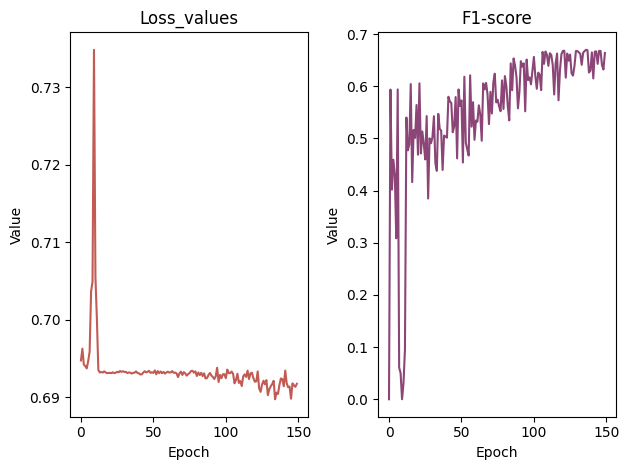

In [112]:
plt.subplot(1, 2, 1)
plt.plot(loss_values, color='#c25b53')
plt.title('Loss_values')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(f1_values, color='#8c4577')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

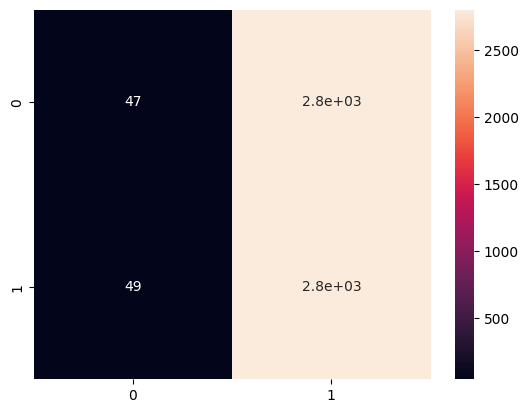

array([[  47, 2800],
       [  49, 2798]])

In [113]:
matrix = compute_conf_matrix(positive_prob_GD, negative_prob_GD)
sns.heatmap(matrix, annot=True)
plt.show()
matrix

TP = 47: истинно положительных предсказаний.\
FP = 2800: ложно позитивных предсказаний.\
FN = 49: ложно негативных предсказаний.\
TN = 2798: истинно позитивных предсказаний.

Высокое количество FP: Модель ошибочно классифицирует много отрицательных примеров как положительные\
Максимальное TN: Модель правильно классифицирует отрицательные примеры\
Низкое количество TP: Модель не может прежсказывать положительные примеры\

In [133]:
TP2, FP2, FN2, TN2 = 47, 2800, 49, 2798

### 9.2.1 Кросс-валидация

In [114]:
kf = KFold(n_splits=5)
loss_values, f1_values = [], []
accuracies, f1_scores, auc_scores = [], [], []
start_time = time.time()

for fold, (train_index, val_index) in enumerate(kf.split(train_g.ndata["products"])):
    print(f"Fold {fold+1}")

    # Создание тренировочных и валидационных наборов данных
    train_subset = train_index
    val_subset = val_index

    # Обучение модели
    model2 = GCN(train_g.ndata["products"].shape[1], 128, 2).double()
    predictor1 = DotPredictor()
    optimizer = torch.optim.SGD(
        itertools.chain(model2.parameters(), predictor1.parameters()), lr=0.01
    )

    for i in range(100):
        model2.train()
        h1 = model2(train_g, train_g.ndata["products"])
        positive_score = predictor1(train_pos_g, h1)
        negative_score = predictor1(train_negative_g, h1)
        loss = compute_loss(positive_score, negative_score)
        accuracy = round(compute_accuracy(positive_score, negative_score), 5)
        f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"In epoch {i}, Loss: {round(loss.item(), 5)}, Accuracy: {accuracy}")

    model2.eval()
    with torch.no_grad():
        h1 = model2(train_g, train_g.ndata["products"])
        positive_score_GD = predictor1(test_pos_g, h1)
        negative_score_GD = predictor1(test_negative_g, h1)
        positive_prob_GD = torch.sigmoid(positive_score_GD)
        negative_prob_GD = torch.sigmoid(negative_score_GD)

        accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
        f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
        auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)

        accuracies.append(accurary)
        f1_scores.append(f1)
        auc_scores.append(auc_)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.5f}")
print(f"Average F1_score: {sum(f1_scores) / len(f1_scores):.5f}")
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.5f}")
print(f"Elapsed Time: {elapsed_time:.5f}")

Fold 1
In epoch 0, Loss: 0.70051, Accuracy: 0.49165
In epoch 10, Loss: 0.69395, Accuracy: 0.49838
In epoch 20, Loss: 0.69343, Accuracy: 0.49879
In epoch 30, Loss: 0.69347, Accuracy: 0.49914
In epoch 40, Loss: 0.69347, Accuracy: 0.49897
In epoch 50, Loss: 0.69362, Accuracy: 0.49918
In epoch 60, Loss: 0.69342, Accuracy: 0.49899
In epoch 70, Loss: 0.69336, Accuracy: 0.4993
In epoch 80, Loss: 0.69338, Accuracy: 0.49904
In epoch 90, Loss: 0.69346, Accuracy: 0.49887
Fold 2
In epoch 0, Loss: 0.73101, Accuracy: 0.46226
In epoch 10, Loss: 0.69438, Accuracy: 0.49828
In epoch 20, Loss: 0.69345, Accuracy: 0.49912
In epoch 30, Loss: 0.69325, Accuracy: 0.49932
In epoch 40, Loss: 0.69356, Accuracy: 0.49906
In epoch 50, Loss: 0.69339, Accuracy: 0.49914
In epoch 60, Loss: 0.69334, Accuracy: 0.49934
In epoch 70, Loss: 0.69371, Accuracy: 0.49926
In epoch 80, Loss: 0.69361, Accuracy: 0.49926
In epoch 90, Loss: 0.69342, Accuracy: 0.49943
Fold 3
In epoch 0, Loss: 0.71007, Accuracy: 0.48283
In epoch 10, Loss

Потери стабилизируются около 0.693, что очень близко к значению для случайного угадывания в бинарной классификации

Точность в каждой эпохе и каждом фолде стабилизируется около 0.499, что указывает на случайное угадывание.\
Средняя точность по всем фолдам равна 0.50000, что является показателем случайного угадывания в бинарной классификации.

Средний F1-Score очень низкий — 0.06351. Это говорит о том, что модель плохо различает классы и не умеет правильно предсказывать положительные и отрицательные классы.

Средний AUC равен 0.176922, что значительно ниже 0.5 и указывает на плохое качество классификации. Модель хуже, чем случайное угадывание.

In [134]:
Average_Accuracy2 = 0.50000
Average_F1_score2 = 0.06351
Average_AUC2 = 0.17692
Elapsed_Time2 = 162.28115

In [135]:
torch.save(model2.state_dict(), 'model2.pth')
torch.save(predictor1.state_dict(), 'predictor1.pth')

## 9.3 GraphConv_x3 (3 слоя)

In [115]:
class GCN(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(n_input, n_hidden, allow_zero_in_degree=True)
        self.conv2 = GraphConv(n_hidden, n_hidden, allow_zero_in_degree=True)
        self.conv3 = GraphConv(n_hidden, n_output, allow_zero_in_degree=True)
        self.dropout = dropout
        self.batch_norm1 = nn.BatchNorm1d(n_hidden)
        self.batch_norm2 = nn.BatchNorm1d(n_hidden)

    def forward(self, g, in_features):
        out = F.elu(self.batch_norm1(self.conv1(g, in_features)))
        out = F.dropout(out, self.dropout, training=self.training)
        out = F.elu(self.batch_norm2(self.conv2(g, out)))
        out = F.dropout(out, self.dropout, training=self.training)
        out = self.conv3(g, out)
        return out

In [116]:
model3 = GCN(train_g.ndata["products"].shape[1], 128, 2)
model3 = model3.double()
predictor1 = DotPredictor()
optimizer = torch.optim.SGD(
    itertools.chain(model3.parameters(), predictor1.parameters()), lr=0.01
)

loss_values, f1_values = [], []
start_time = time.time()
for i in range(100):
    h1 = model3(train_g, train_g.ndata["products"])
    positive_score = predictor1(train_pos_g, h1)
    negative_score = predictor1(train_negative_g, h1)
    loss = compute_loss(positive_score, negative_score)
    accuracy = round(compute_accuracy(positive_score, negative_score), 5)
    f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())
    loss = round(loss.item(), 5)
    f1_values.append(f1_sc)

    if i % 10 == 0:
        print(f"In epoch {i}, Loss: {loss}, Accuracy: {accuracy}")
end_time = time.time()
elapsed_time = end_time - start_time


with torch.no_grad():
    positive_score_GD = predictor1(test_pos_g, h1)
    negative_score_GD = predictor1(test_negative_g, h1)
    positive_prob_GD = torch.sigmoid(positive_score_GD)
    negative_prob_GD = torch.sigmoid(negative_score_GD)

def metrics():
  accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
  f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
  auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)
  t = round(elapsed_time, 5)
  return accurary, f1, auc_, t

accurary3, f13, auc_3, t3 = metrics()
print ('Accuracy = :', accurary3)
print ('F1_score = :', f13)
print ('Auc = :', auc_3)
print('Time =', t3)

In epoch 0, Loss: 0.70786, Accuracy: 0.48336
In epoch 10, Loss: 0.69369, Accuracy: 0.49752
In epoch 20, Loss: 0.69399, Accuracy: 0.4976
In epoch 30, Loss: 0.69361, Accuracy: 0.49791
In epoch 40, Loss: 0.69348, Accuracy: 0.49815
In epoch 50, Loss: 0.6938, Accuracy: 0.49756
In epoch 60, Loss: 0.69384, Accuracy: 0.49789
In epoch 70, Loss: 0.69396, Accuracy: 0.49764
In epoch 80, Loss: 0.69398, Accuracy: 0.49774
In epoch 90, Loss: 0.69373, Accuracy: 0.49803
Accuracy = : 0.4986
F1_score = : 0.56352
Auc = : 0.57885
Time = 37.05989


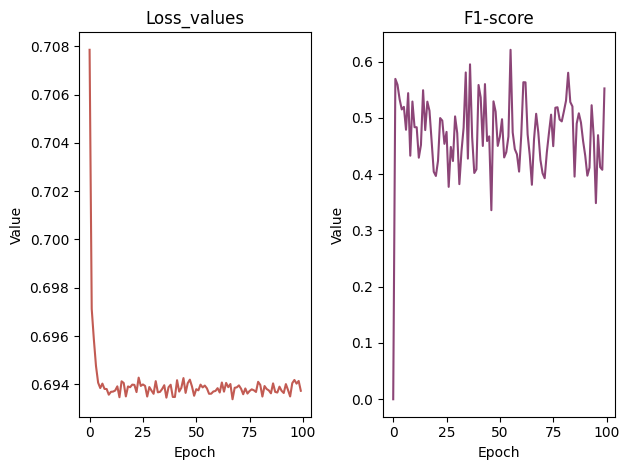

In [117]:
plt.subplot(1, 2, 1)
plt.plot(loss_values, color='#c25b53')
plt.title('Loss_values')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(f1_values, color='#8c4577')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

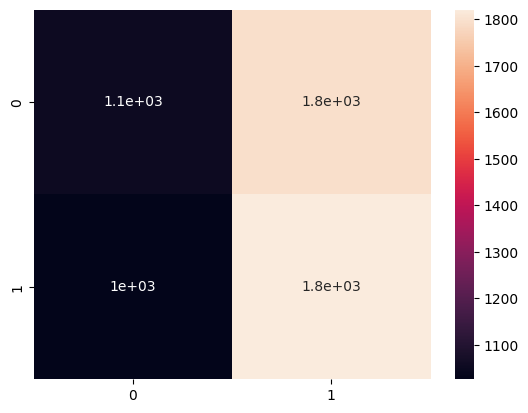

array([[1052, 1795],
       [1026, 1821]])

In [118]:
matrix = compute_conf_matrix(positive_prob_GD, negative_prob_GD)
sns.heatmap(matrix, annot=True)
plt.show()
matrix

TP = 1052: истинно позитивных предсказаний\
FP = 1795: ложно позитивных предсказаний.\
FN = 1026: ложно негативных предсказаний.\
TN = 1821: истинно негативных предсказаний.

Высокое количество FP и FN: Модель ошибочно классифицирует много отрицательных примеров как положительные и наоборот\
Однако по сравнению с прошлой моделью, эта хотя бы делает предсказания касаемо положительного класса.\
Также стоит отметить, что эта модель предсказывает лучше негативные связи

In [136]:
TP3, FP3, FN3, TN3 = 1052, 1795, 1025, 1821

### 9.3.1 Кросс-валидация

In [119]:
kf = KFold(n_splits=5)
loss_values, f1_values = [], []
accuracies, f1_scores, auc_scores = [], [], []
start_time = time.time()

for fold, (train_index, val_index) in enumerate(kf.split(train_g.ndata["products"])):
    print(f"Fold {fold+1}")

    # Создание тренировочных и валидационных наборов данных
    train_subset = train_index
    val_subset = val_index

    # Обучение модели
    model3 = GCN(train_g.ndata["products"].shape[1], 128, 2).double()
    predictor1 = DotPredictor()
    optimizer = torch.optim.SGD(
        itertools.chain(model3.parameters(), predictor1.parameters()), lr=0.01
    )

    for i in range(100):
        model3.train()
        h1 = model3(train_g, train_g.ndata["products"])
        positive_score = predictor1(train_pos_g, h1)
        negative_score = predictor1(train_negative_g, h1)
        loss = compute_loss(positive_score, negative_score)
        accuracy = round(compute_accuracy(positive_score, negative_score), 5)
        f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"In epoch {i}, Loss: {round(loss.item(), 5)}, Accuracy: {accuracy}")

    model3.eval()
    with torch.no_grad():
        h1 = model3(train_g, train_g.ndata["products"])
        positive_score_GD = predictor1(test_pos_g, h1)
        negative_score_GD = predictor1(test_negative_g, h1)
        positive_prob_GD = torch.sigmoid(positive_score_GD)
        negative_prob_GD = torch.sigmoid(negative_score_GD)

        accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
        f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
        auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)

        accuracies.append(accurary)
        f1_scores.append(f1)
        auc_scores.append(auc_)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.5f}")
print(f"Average F1_score: {sum(f1_scores) / len(f1_scores):.5f}")
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.5f}")
print(f"Elapsed Time: {elapsed_time:.5f}")

Fold 1
In epoch 0, Loss: 0.72659, Accuracy: 0.46712
In epoch 10, Loss: 0.69442, Accuracy: 0.4969
In epoch 20, Loss: 0.69369, Accuracy: 0.49705
In epoch 30, Loss: 0.69372, Accuracy: 0.49756
In epoch 40, Loss: 0.69432, Accuracy: 0.49643
In epoch 50, Loss: 0.69363, Accuracy: 0.49717
In epoch 60, Loss: 0.69425, Accuracy: 0.49694
In epoch 70, Loss: 0.69411, Accuracy: 0.49711
In epoch 80, Loss: 0.69384, Accuracy: 0.497
In epoch 90, Loss: 0.6937, Accuracy: 0.49764
Fold 2
In epoch 0, Loss: 0.69649, Accuracy: 0.496
In epoch 10, Loss: 0.69354, Accuracy: 0.49863
In epoch 20, Loss: 0.69343, Accuracy: 0.49902
In epoch 30, Loss: 0.69323, Accuracy: 0.49897
In epoch 40, Loss: 0.69354, Accuracy: 0.49883
In epoch 50, Loss: 0.6936, Accuracy: 0.49867
In epoch 60, Loss: 0.69349, Accuracy: 0.49846
In epoch 70, Loss: 0.69327, Accuracy: 0.49904
In epoch 80, Loss: 0.69337, Accuracy: 0.49893
In epoch 90, Loss: 0.69354, Accuracy: 0.49861
Fold 3
In epoch 0, Loss: 0.69661, Accuracy: 0.49483
In epoch 10, Loss: 0.69

Accuracy = 0.50000 показывает, что модель правильно классифицирует примерно половину примеров. Это не лучше случайного угадывания для задачи бинарной классификации.

F1-score значение 0.57147 указывает на более высокую производительность по сравнению с точностью, особенно учитывая сбалансированный вклад точности и полноты. F1-score выше, чем точность, может указывать на то, что модель лучше работает с одним из классов.

AUC значение 0.54921 выше 0.5, что указывает лучшее угадывание, чем случайное, но еще далекое от идеала

In [137]:
Average_Accuracy3 = 0.50000
Average_F1_score3 = 0.57147
Average_AUC3 = 0.54921
Elapsed_Time3 = 175.39032

In [138]:
torch.save(model3.state_dict(), 'model3.pth')
torch.save(predictor1.state_dict(), 'predictor1.pth')

## 9.4 SAGEConv (собственный)

In [120]:
class SAGEConv(nn.Module):
    def __init__(self, in_feat, out_feat, dropout=0.2):
        super(SAGEConv, self).__init__()
        self.linear = nn.Linear(in_feat * 2, out_feat)
        self.batchnorm = nn.BatchNorm1d(out_feat)
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            g.update_all(
                message_func=fn.copy_u("h", "m"),
                reduce_func=fn.mean("m", "h_N"),
            )
            h_N = g.ndata["h_N"]
            h_total = torch.cat([h, h_N], dim=1)
            h_total = self.linear(h_total)
            h_total = self.batchnorm(h_total)
            h_total = self.dropout(h_total)
            return h_total

class Model(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats)
        self.conv2 = SAGEConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [121]:
model4 = Model(train_g.ndata["products"].shape[1], 128, 2)
model4 = model4.double()
predictor1 = DotPredictor()
optimizer = torch.optim.Adam(
    itertools.chain(model4.parameters(), predictor1.parameters()), lr=0.001
)

loss_values, f1_values = [], []
start_time = time.time()
for i in range(110):
    h1 = model4(train_g, train_g.ndata["products"])
    positive_score = predictor1(train_pos_g, h1)
    negative_score = predictor1(train_negative_g, h1)
    loss = compute_loss(positive_score, negative_score)
    accuracy = round(compute_accuracy(positive_score, negative_score), 5)
    f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())
    loss = round(loss.item(), 5)
    f1_values.append(f1_sc)

    if i % 10 == 0:
        print(f"In epoch {i}, Loss: {loss}, Accuracy: {accuracy}")
end_time = time.time()
elapsed_time = end_time - start_time


with torch.no_grad():
    positive_score_GD = predictor1(test_pos_g, h1)
    negative_score_GD = predictor1(test_negative_g, h1)
    positive_prob_GD = torch.sigmoid(positive_score_GD)
    negative_prob_GD = torch.sigmoid(negative_score_GD)

def metrics():
  accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
  f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
  auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)
  t = round(elapsed_time, 5)
  return accurary, f1, auc_, t

accurary4, f14, auc_4, t4 = metrics()
print ('Accuracy = :', accurary4)
print ('F1_score = :', f14)
print ('Auc = :', auc_4)
print('Time =', t4)

In epoch 0, Loss: 0.88133, Accuracy: 0.49337
In epoch 10, Loss: 0.51888, Accuracy: 0.76463
In epoch 20, Loss: 0.49238, Accuracy: 0.78598
In epoch 30, Loss: 0.5113, Accuracy: 0.7429
In epoch 40, Loss: 0.4486, Accuracy: 0.82559
In epoch 50, Loss: 0.45542, Accuracy: 0.80639
In epoch 60, Loss: 0.45313, Accuracy: 0.80368
In epoch 70, Loss: 0.42708, Accuracy: 0.84038
In epoch 80, Loss: 0.46009, Accuracy: 0.78951
In epoch 90, Loss: 0.42456, Accuracy: 0.83262
In epoch 100, Loss: 0.47849, Accuracy: 0.75987
Accuracy = : 0.76361
F1_score = : 0.72004
Auc = : 0.84832
Time = 82.95597


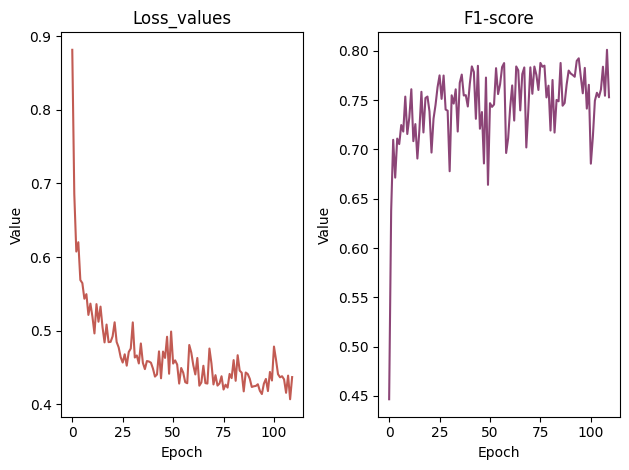

In [122]:
plt.subplot(1, 2, 1)
plt.plot(loss_values, color='#c25b53')
plt.title('Loss_values')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(f1_values, color='#8c4577')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

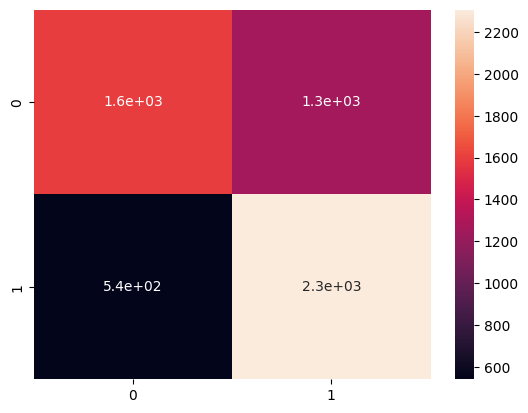

array([[1593, 1254],
       [ 540, 2307]])

In [123]:
matrix = compute_conf_matrix(positive_prob_GD, negative_prob_GD)
sns.heatmap(matrix, annot=True)
plt.show()
matrix

TP = 1593: истинно позитивных предсказаний\
FP = 1254: ложно позитивных предсказаний.\
FN = 540: ложно негативных предсказаний.\
TN = 2307: истинно негативных предсказаний.

Высокое количество TP и TN: Модель правильно классифицирует много положительных и отрицательных примеров (однако отрицательные примерны классифицирует лучше)\
Высокое количество FP: Модель все еще ошибочно классифицирует много отрицательных примеров как положительные, но по сравнению с другими моделями это пока самый лучший результат\
Низкое количество FN: Модель правильно классифицирует отрицательные примеры.

In [139]:
TP4, FP4, FN4, TN4 = 1593, 1254, 540, 2307

### 9.4.1 Кросс-валидация

In [124]:
kf = KFold(n_splits=5)
loss_values, f1_values = [], []
accuracies, f1_scores, auc_scores = [], [], []
start_time = time.time()

for fold, (train_index, val_index) in enumerate(kf.split(train_g.ndata["products"])):
    print(f"Fold {fold+1}")

    # Создание тренировочных и валидационных наборов данных
    train_subset = train_index
    val_subset = val_index

    # Обучение модели
    model4 = Model(train_g.ndata["products"].shape[1], 128, 2).double()
    predictor1 = DotPredictor()
    optimizer = torch.optim.Adam(
        itertools.chain(model4.parameters(), predictor1.parameters()), lr=0.001
    )

    for i in range(100):
        model4.train()
        h1 = model4(train_g, train_g.ndata["products"])
        positive_score = predictor1(train_pos_g, h1)
        negative_score = predictor1(train_negative_g, h1)
        loss = compute_loss(positive_score, negative_score)
        accuracy = round(compute_accuracy(positive_score, negative_score), 5)
        f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"In epoch {i}, Loss: {round(loss.item(), 5)}, Accuracy: {accuracy}")

    model4.eval()
    with torch.no_grad():
        h1 = model4(train_g, train_g.ndata["products"])
        positive_score_GD = predictor1(test_pos_g, h1)
        negative_score_GD = predictor1(test_negative_g, h1)
        positive_prob_GD = torch.sigmoid(positive_score_GD)
        negative_prob_GD = torch.sigmoid(negative_score_GD)

        accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
        f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
        auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)

        accuracies.append(accurary)
        f1_scores.append(f1)
        auc_scores.append(auc_)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.5f}")
print(f"Average F1_score: {sum(f1_scores) / len(f1_scores):.5f}")
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.5f}")
print(f"Elapsed Time: {elapsed_time:.5f}")

Fold 1
In epoch 0, Loss: 0.97159, Accuracy: 0.47664
In epoch 10, Loss: 0.53285, Accuracy: 0.74731
In epoch 20, Loss: 0.49712, Accuracy: 0.77369
In epoch 30, Loss: 0.46675, Accuracy: 0.80651
In epoch 40, Loss: 0.44265, Accuracy: 0.83562
In epoch 50, Loss: 0.44374, Accuracy: 0.82589
In epoch 60, Loss: 0.43362, Accuracy: 0.83638
In epoch 70, Loss: 0.42756, Accuracy: 0.83832
In epoch 80, Loss: 0.44537, Accuracy: 0.80733
In epoch 90, Loss: 0.45167, Accuracy: 0.80366
Fold 2
In epoch 0, Loss: 0.80615, Accuracy: 0.53395
In epoch 10, Loss: 0.50795, Accuracy: 0.77872
In epoch 20, Loss: 0.50576, Accuracy: 0.75818
In epoch 30, Loss: 0.4799, Accuracy: 0.77945
In epoch 40, Loss: 0.44706, Accuracy: 0.82721
In epoch 50, Loss: 0.43793, Accuracy: 0.83016
In epoch 60, Loss: 0.45383, Accuracy: 0.80575
In epoch 70, Loss: 0.45954, Accuracy: 0.79273
In epoch 80, Loss: 0.43887, Accuracy: 0.81519
In epoch 90, Loss: 0.42544, Accuracy: 0.83613
Fold 3
In epoch 0, Loss: 0.8092, Accuracy: 0.54344
In epoch 10, Loss:

Accuracy = 0.84261 показывает, что модель правильно классифицирует примерно 84% примеров.

F1-score значение 0.77769, что значит, что модель достаточно хорошо сбалансирована между точностью и полнотой

AUC значение 0.92502 указывает на очень хорошую способность модели различать классы

In [140]:
Average_Accuracy4 = 0.84261
Average_F1_score4 = 0.77769
Average_AUC4 = 0.92502
Elapsed_Time4 = 397.26092

In [141]:
torch.save(model4.state_dict(), 'model4.pth')
torch.save(predictor1.state_dict(), 'predictor1.pth')

## 9.5 WeightedSAGEConv (собственный)

In [125]:
class WeightedSAGEConv(nn.Module):
    def __init__(self, in_feat, out_feat, dropout=0.5):
        super(WeightedSAGEConv, self).__init__()
        self.linear = nn.Linear(in_feat * 2, out_feat)
        self.batchnorm = nn.BatchNorm1d(out_feat)
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, h, w):
        with g.local_scope():
            g.ndata["h"] = h
            g.edata["w"] = w
            g.update_all(
                message_func=fn.u_mul_e("h", "w", "m"),
                reduce_func=fn.mean("m", "h_N"),
            )
            h_N = g.ndata["h_N"]
            h_total = torch.cat([h, h_N], dim=1)
            h_total = self.linear(h_total)
            h_total = self.batchnorm(h_total)
            h_total = self.dropout(h_total)
            return h_total

class Model(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model, self).__init__()
        self.conv1 = WeightedSAGEConv(in_feats, h_feats)
        self.conv2 = WeightedSAGEConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        edge_weights = torch.ones(g.num_edges(), 1, dtype=in_feat.dtype)
        h = self.conv1(g, in_feat, edge_weights)
        h = F.relu(h)
        h = self.conv2(g, h, edge_weights)
        return h

In [126]:
model5 = Model(train_g.ndata["products"].shape[1], 128, 2)
model5 = model5.double()
predictor1 = DotPredictor()
optimizer = torch.optim.SGD(
    itertools.chain(model5.parameters(), predictor1.parameters()), lr=0.002
)

loss_values, f1_values = [], []
start_time = time.time()
for i in range(120):
    h1 = model5(train_g, train_g.ndata["products"])
    positive_score = predictor1(train_pos_g, h1)
    negative_score = predictor1(train_negative_g, h1)
    loss = compute_loss(positive_score, negative_score)
    accuracy = round(compute_accuracy(positive_score, negative_score), 5)
    f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())
    loss = round(loss.item(), 5)
    f1_values.append(f1_sc)

    if i % 10 == 0:
        print(f"In epoch {i}, Loss: {loss}, Accuracy: {accuracy}")
end_time = time.time()
elapsed_time = end_time - start_time


with torch.no_grad():
    positive_score_GD = predictor1(test_pos_g, h1)
    negative_score_GD = predictor1(test_negative_g, h1)
    positive_prob_GD = torch.sigmoid(positive_score_GD)
    negative_prob_GD = torch.sigmoid(negative_score_GD)

def metrics():
  accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
  f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
  auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)
  t = round(elapsed_time, 5)
  return accurary, f1, auc_, t

accurary5, f15, auc_5, t5 = metrics()
print ('Accuracy = :', accurary5)
print ('F1_score = :', f15)
print ('Auc = :', auc_5)
print('Time =', t5)

In epoch 0, Loss: 0.97831, Accuracy: 0.50117
In epoch 10, Loss: 0.91292, Accuracy: 0.53647
In epoch 20, Loss: 0.85763, Accuracy: 0.56152
In epoch 30, Loss: 0.83633, Accuracy: 0.56923
In epoch 40, Loss: 0.8296, Accuracy: 0.55066
In epoch 50, Loss: 0.80561, Accuracy: 0.57038
In epoch 60, Loss: 0.81121, Accuracy: 0.51826
In epoch 70, Loss: 0.7657, Accuracy: 0.56611
In epoch 80, Loss: 0.74953, Accuracy: 0.58845
In epoch 90, Loss: 0.75436, Accuracy: 0.5639
In epoch 100, Loss: 0.76573, Accuracy: 0.54812
In epoch 110, Loss: 0.73681, Accuracy: 0.5739
Accuracy = : 0.63347
F1_score = : 0.56242
Auc = : 0.68056
Time = 102.46491


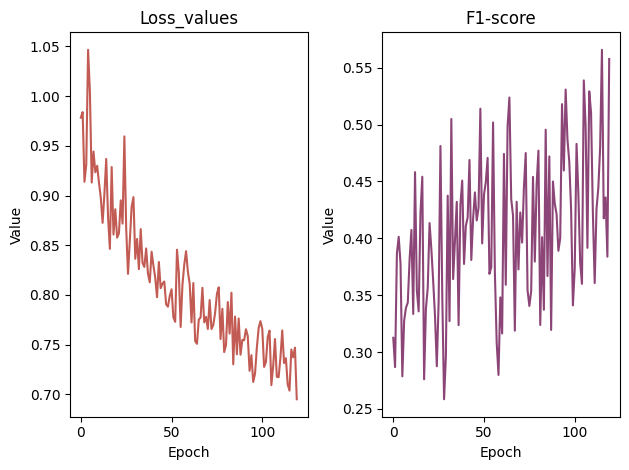

In [127]:
plt.subplot(1, 2, 1)
plt.plot(loss_values, color='#c25b53')
plt.title('Loss_values')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(f1_values, color='#8c4577')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

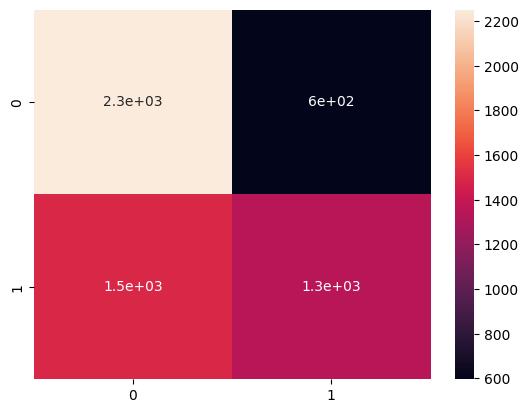

array([[2251,  596],
       [1500, 1347]])

In [128]:
matrix = compute_conf_matrix(positive_prob_GD, negative_prob_GD)
sns.heatmap(matrix, annot=True)
plt.show()
matrix

TP = 2251: истинно позитивных предсказаний\
FP = 596: ложно позитивных предсказаний.\
FN = 1500: ложно негативных предсказаний.\
TN = 1347: истинно негативных предсказаний.

Высокое количество TP: Модель правильно классифицирует много положительных примеров\
Маленькое количество TN: Модель плохо классифицирует отрицательные примеры\
Высокое количество FN: Модель ошибочно классифицирует много положительных примеров как отрицательные

In [142]:
TP5, FP5, FN5, TN5 = 2251, 596, 1500, 1347

### 9.5.1 Кросс-валидация

In [129]:
kf = KFold(n_splits=5)
loss_values, f1_values = [], []
accuracies, f1_scores, auc_scores = [], [], []
start_time = time.time()

for fold, (train_index, val_index) in enumerate(kf.split(train_g.ndata["products"])):
    print(f"Fold {fold+1}")

    # Создание тренировочных и валидационных наборов данных
    train_subset = train_index
    val_subset = val_index

    # Обучение модели
    model5 = Model(train_g.ndata["products"].shape[1], 128, 2).double()
    predictor1 = DotPredictor()
    optimizer = torch.optim.SGD(
        itertools.chain(model5.parameters(), predictor1.parameters()), lr=0.1
    )

    for i in range(100):
        model5.train()
        h1 = model5(train_g, train_g.ndata["products"])
        positive_score = predictor1(train_pos_g, h1)
        negative_score = predictor1(train_negative_g, h1)
        loss = compute_loss(positive_score, negative_score)
        accuracy = round(compute_accuracy(positive_score, negative_score), 5)
        f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"In epoch {i}, Loss: {round(loss.item(), 5)}, Accuracy: {accuracy}")

    model5.eval()
    with torch.no_grad():
        h1 = model5(train_g, train_g.ndata["products"])
        positive_score_GD = predictor1(test_pos_g, h1)
        negative_score_GD = predictor1(test_negative_g, h1)
        positive_prob_GD = torch.sigmoid(positive_score_GD)
        negative_prob_GD = torch.sigmoid(negative_score_GD)

        accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
        f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
        auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)

        accuracies.append(accurary)
        f1_scores.append(f1)
        auc_scores.append(auc_)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.5f}")
print(f"Average F1_score: {sum(f1_scores) / len(f1_scores):.5f}")
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.5f}")
print(f"Elapsed Time: {elapsed_time:.5f}")

Fold 1
In epoch 0, Loss: 0.99614, Accuracy: 0.46773
In epoch 10, Loss: 0.66271, Accuracy: 0.58722
In epoch 20, Loss: 0.67215, Accuracy: 0.56769
In epoch 30, Loss: 0.62745, Accuracy: 0.62861
In epoch 40, Loss: 0.60005, Accuracy: 0.66241
In epoch 50, Loss: 0.64969, Accuracy: 0.57979
In epoch 60, Loss: 0.59737, Accuracy: 0.65228
In epoch 70, Loss: 0.63853, Accuracy: 0.59113
In epoch 80, Loss: 0.6323, Accuracy: 0.60125
In epoch 90, Loss: 0.60217, Accuracy: 0.65306
Fold 2
In epoch 0, Loss: 0.95088, Accuracy: 0.52451
In epoch 10, Loss: 0.6861, Accuracy: 0.56867
In epoch 20, Loss: 0.66167, Accuracy: 0.57155
In epoch 30, Loss: 0.65573, Accuracy: 0.58018
In epoch 40, Loss: 0.65757, Accuracy: 0.57924
In epoch 50, Loss: 0.66657, Accuracy: 0.56047
In epoch 60, Loss: 0.63815, Accuracy: 0.60135
In epoch 70, Loss: 0.6468, Accuracy: 0.58193
In epoch 80, Loss: 0.5956, Accuracy: 0.65121
In epoch 90, Loss: 0.63278, Accuracy: 0.60525
Fold 3
In epoch 0, Loss: 0.9405, Accuracy: 0.53354
In epoch 10, Loss: 0.

Accuracy = 0.7738 показывает, что модель правильно классифицирует примерно 78% примеров.

F1-score значение 0.76778, что значит, что модель достаточно хорошо сбалансирована между точностью и полнотой

AUC значение 0.89654 указывает на хорошую способность модели различать классы

In [144]:
Average_Accuracy5 = 0.77738
Average_F1_score5 = 0.76778
Average_AUC5 = 0.89654
Elapsed_Time5 = 421.19714

In [145]:
torch.save(model5.state_dict(), 'model5.pth')
torch.save(predictor1.state_dict(), 'predictor1.pth')

# 10 Результаты

In [146]:
a = [accurary1, accurary2, accurary3, accurary4, accurary5]
f = [f11, f12, f13, f14, f15]
au = [auc_1, auc_2, auc_3, auc_4, auc_5]
t = [t1, t2, t3, t4, t5]
TP = [TP1,TP2,TP3,TP4,TP5]
FP = [FP1,FP2,FP3,FP4,FP5]
FN = [FN1,FN2,FN3,FN4,FN5]
TN = [TN1,TN2,TN3,TN4,TN5]
v_a = [Average_Accuracy1, Average_Accuracy2, Average_Accuracy3, Average_Accuracy4, Average_Accuracy5]
v_f = [Average_F1_score1, Average_F1_score2,Average_F1_score3,Average_F1_score4, Average_F1_score5]
v_au = [Average_AUC1, Average_AUC2, Average_AUC3, Average_AUC4, Average_AUC5]
v_t = [Elapsed_Time1, Elapsed_Time2, Elapsed_Time3, Elapsed_Time4, Elapsed_Time5]
res_d = {'accurary': a, 'f1-score': f, 'AUC': au, 'time': t,
         'TP':TP, 'FP':FP, 'FN':FN, 'TN':TN,
         'val_accuracy': v_a, 'val_f1-score': v_f, 'val_AUC': v_au, 'val_time': v_t}
index_values = ['GraphSAGE', 'GraphConv_x2', 'GraphConv_x3', 'SAGEConv', 'WeightedSAGEConv']
res_df = pd.DataFrame(res_d)
res_df = res_df.set_index(pd.Index(index_values))
res_df

,accurary,f1-score,AUC,time,TP,FP,FN,TN,val_accuracy,val_f1-score,val_AUC,val_time
GraphSAGE,0.82297,0.77970,0.90272,30.03857,1401,1446,104,2743,0.71900,0.74145,0.82577,138.20209
GraphConv_x2,0.49895,0.66264,0.59500,62.42737,47,2800,49,2798,0.50000,0.06351,0.17692,162.28115
GraphConv_x3,0.49860,0.56352,0.57885,37.05989,1052,1795,1025,1821,0.50000,0.57147,0.54921,175.39032
SAGEConv,0.76361,0.72004,0.84832,82.95597,1593,1254,540,2307,0.84261,0.77769,0.92502,397.26092
WeightedSAGEConv,0.63347,0.56242,0.68056,102.46491,2251,596,1500,1347,0.77738,0.76778,0.89654,421.19714


In [147]:
res_df.sort_values('f1-score', ascending=False)

,accurary,f1-score,AUC,time,TP,FP,FN,TN,val_accuracy,val_f1-score,val_AUC,val_time
GraphSAGE,0.82297,0.77970,0.90272,30.03857,1401,1446,104,2743,0.71900,0.74145,0.82577,138.20209
SAGEConv,0.76361,0.72004,0.84832,82.95597,1593,1254,540,2307,0.84261,0.77769,0.92502,397.26092
GraphConv_x2,0.49895,0.66264,0.59500,62.42737,47,2800,49,2798,0.50000,0.06351,0.17692,162.28115
GraphConv_x3,0.49860,0.56352,0.57885,37.05989,1052,1795,1025,1821,0.50000,0.57147,0.54921,175.39032
WeightedSAGEConv,0.63347,0.56242,0.68056,102.46491,2251,596,1500,1347,0.77738,0.76778,0.89654,421.19714


Для построния рекомендаций попробуем использовать две модели GraphSAGE и
SAGEConv.\
GraphSAGE имеет на тестовом наборе лучшие метрики и предсказывает лучше негативные примеры. В то время как SAGEConv имеет лучшие метрике на кросс-валидации и предсказывает лучше позитивные примеры



# 11. Рекомендации

Для получения рекомендаций использована модель GraphSAGE

In [197]:
df = pd.read_csv('all_data.csv')
d_nodes = pd.read_csv('/content/d_nodes.csv')
edges = pd.read_csv('/content/d_edges.csv')
df.head(1)

,ID,customer_name,customer_INN,order_price,provider_name,provider_INN,product
0,747261344941507,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.01,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...


In [198]:
# ИНН и их номер
all_inn = sorted(pd.concat([edges['customer_INN'], edges['provider_INN']]).unique().tolist())
counter = {val: i for i, val in enumerate(all_inn)}

In [150]:
def get_value_by_key(dictionary, keyy):
    for key, val in dictionary.items():
        if key == keyy:
            return val
    return None

def get_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None

## 11.2 Информация о заказчике

In [249]:
def info_customer():
  u_inns = sorted(df['customer_INN'].unique())
  random_index = random.randint(0, len(u_inns) - 1)
  selected_inn = u_inns[random_index]
  noda = get_value_by_key(counter, selected_inn)
  print('ИНФОРМАЦИЯ О ЗАКАЗЧИКЕ')
  print("ИНН случайно выбранного заказчика:", selected_inn)
  print("Наименование выбранного заказчика:", list(df[df['customer_INN']==selected_inn]['customer_name'])[0])
  print("Вершина в графе = ", noda)
  print('Продукты/услуги')
  products = list(set((df[df['customer_INN']==selected_inn]['product'])))
  for p in products:
    print(p)
  return noda

## 11.3 Поиск всех поставщиков из истории выполнения заказов

In [296]:
def get_from_history(noda):
  print('ПОСТАВЩИКИ, КОТОРЫЕ УЖЕ ВЫПОЛНЯЛИ ЗАКАЗ ЭТОГО ЗАКАЗЧИКА')
  all_providers = list(set(nodes[nodes['customer_INN'] == noda]['provider_INN']))
  for p in all_providers:
    inn = get_key_by_value(counter, p)
    name = list(df[df['provider_INN'] == inn]['provider_name'])[0]
    print('ИНН поставщика:', inn)
    print("Наименование поставщика:", name)
    #print('Продукты/услуги:', list(df[df['provider_INN'] == inn]['product'])[0])
    print('Вершина в графе =', p)
    print('')

## 11.4 Рекомендательная система

In [297]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hid_feats):
        super(GraphSAGE, self).__init__()
        self.layer1 = SAGEConv(in_feats, hid_feats, 'mean')
        self.layer2 = SAGEConv(hid_feats, hid_feats, 'mean')

    def forward(self, g, features):
        h = self.layer1(g, features)
        h = F.relu(h)
        h = self.layer2(g,h)
        return h
model1 = GraphSAGE(train_g.ndata["products"].shape[1], 2)
model1 = model1.double()
predictor1 = DotPredictor()
model1.load_state_dict(torch.load('model1.pth'))
predictor1.load_state_dict(torch.load('predictor1.pth'))
model1.eval()
predictor1.eval()

DotPredictor()

In [298]:
def recommend_suppliers(model, predictor, graph, customer_node, top_k=3):
    model.eval()
    predictor.eval()

    h = model(graph, graph.ndata['products'])

    suppliers = torch.arange(graph.num_nodes())

    # Исключаем уже существующих поставщиков
    existing_suppliers = graph.successors(customer_node).numpy()
    potential_suppliers = [s for s in suppliers if s not in existing_suppliers and s != customer_node]
    # Создаем подграф для предсказания
    potential_edges = [(customer_node, sup) for sup in potential_suppliers]
    subgraph = dgl.graph(potential_edges, num_nodes=graph.num_nodes())

    # Получение оценок совместимости
    scores = predictor(subgraph, h)
    top_suppliers_indices = torch.topk(scores, top_k).indices
    top_suppliers = [potential_suppliers[i] for i in top_suppliers_indices]

    for i in top_suppliers:
      print('Вершина = ', int(i))
      inn = get_key_by_value(counter, i)
      print(inn)
      print(list(df[df['provider_INN'] == inn]['provider_name'])[0])
      print('')

    return top_suppliers

### 11.5 Пример


In [299]:
noda = info_customer()
print()
print()
get_from_history(noda)

ИНФОРМАЦИЯ О ЗАКАЗЧИКЕ
ИНН случайно выбранного заказчика: 7451054040
Наименование выбранного заказчика: МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ "ДЕТСКИЙ САД № 147 Г. ЧЕЛЯБИНСКА"
Вершина в графе =  2543
Продукты/услуги
Яйца куриные в скорлупе свежие 'поставка яиц куриных в скорлупе свежих'


ПОСТАВЩИКИ, КОТОРЫЕ УЖЕ ВЫПОЛНЯЛИ ЗАКАЗ ЭТОГО ЗАКАЗЧИКА
ИНН поставщика: 7729653297
Наименование поставщика: ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "СИТНО-ПРОДУКТ"
Вершина в графе = 2989



In [300]:
recommended_suppliers = recommend_suppliers(model4, predictor1, g, noda)
recommended_suppliers

Вершина =  3222
7811040293
ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ТОРГОВО-ЗАКУПОЧНАЯ БАЗА"

Вершина =  2423
7430035030
ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "РАЙФЕН"

Вершина =  3082
7801301299
ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЛОНГВЕЙ"



[tensor(3222), tensor(2423), tensor(3082)]

### 11.6 Пример 2



In [301]:
noda = info_customer()
print()
print()
get_from_history(noda)

ИНФОРМАЦИЯ О ЗАКАЗЧИКЕ
ИНН случайно выбранного заказчика: 5101110400
Наименование выбранного заказчика: МЕЖМУНИЦИПАЛЬНЫЙ ОТДЕЛ МИНИСТЕРСТВА ВНУТРЕННИХ ДЕЛ РОССИЙСКОЙ ФЕДЕРАЦИИ "АПАТИТСКИЙ"
Вершина в графе =  1886
Продукты/услуги
Услуги по обеспечению питанием (ужин) 'Услуги по обеспечению питанием (г. Апатиты на 24 год) '
Услуги по обеспечению питанием (обед) 'Услуги по обеспечению питанием (г. Апатиты на 24 год) '
Услуги по обеспечению питанием (завтрак) 'Услуги по обеспечению питанием (г. Апатиты на 24 год) '


ПОСТАВЩИКИ, КОТОРЫЕ УЖЕ ВЫПОЛНЯЛИ ЗАКАЗ ЭТОГО ЗАКАЗЧИКА
ИНН поставщика: 5101200365
Наименование поставщика: МУНИЦИПАЛЬНОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ Г. АПАТИТЫ "ЗАПОЛЯРЬЕ"
Вершина в графе = 1887



In [302]:
recommended_suppliers = recommend_suppliers(model4, predictor1, g, noda)
recommended_suppliers

Вершина =  3431
9705122808
ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "НОВЫЕ ТЕХНОЛОГИИ"

Вершина =  740
2635828792
ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ВИКТОРИЯ"

Вершина =  3553
246605903313
СИРЕНКО АНАТОЛЬЕВНА СВЕТЛАНА



[tensor(3431), tensor(740), tensor(3553)]